In [172]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ast import literal_eval as lv
from fmt.data import PathPlanningCSVOperator
from PIL import Image
from scipy.ndimage import uniform_filter1d

In [2]:
with open('config/config.json', 'r') as f:
    cfg = json.load(f)

# FMT*

In [3]:
ALG = 'fmt'
MAPS = {
    2: "Alternating Gaps",
    10: "Bugtrap Forest",
    13: "Forest",
    19: "Gaps Forest",
    24: "Maze",
    28: "Multi Bug Trap",
    37: "Bug Trap"
}
MODE = 'evaluation'
HW = cfg["fmt"]["heuristic_weights"] # FMT* specific (DONT CHANGE!)

In [5]:
dlist = []
# for hw in HW:
#     CSVOperator = PathPlanningCSVOperator(ALG, MODE, f'_hw_{hw}')
#     df = pd.read_csv(CSVOperator.fpath)
#     df["Any Path Found"] = df["Any Path Found"].astype('int')
#     dlist.append(df)

for hw in HW:
    path = './fmt/output/evaluation/fmt_evaluation_hw_{}_results.csv'.format(hw)
    df = pd.read_csv(path)
    df["Any Path Found"] = df["Any Path Found"].astype('int')
    dlist.append(df)


# BIT*

In [6]:
bitdf1 = pd.read_csv('bit_star/results/evaluation_data/batch_size_20/test.csv')
bitdf2 = pd.read_csv('bit_star/results/evaluation_data/batch_size_30/test.csv')
bitdf1["Start Point"] = [str(list(reversed(lv(bitdf1["Start Point"][i])))) for i in range(len(bitdf1))]
bitdf1["Goal Point"] = [str(list(reversed(lv(bitdf1["Goal Point"][i])))) for i in range(len(bitdf1))]
bitdf1["Any Path Found"] = bitdf1["Any Path Found"].astype('int')
bitdf2["Start Point"] = [str(list(reversed(lv(bitdf2["Start Point"][i])))) for i in range(len(bitdf2))]
bitdf2["Goal Point"] = [str(list(reversed(lv(bitdf2["Goal Point"][i])))) for i in range(len(bitdf2))]
bitdf2["Any Path Found"] = bitdf2["Any Path Found"].astype('int')

# NRRT*

In [7]:
nrrt_df = pd.read_csv('nrrt/results/nrrt_results.csv')

> **_NOTE:_**  Add grid-plot showing the maps used

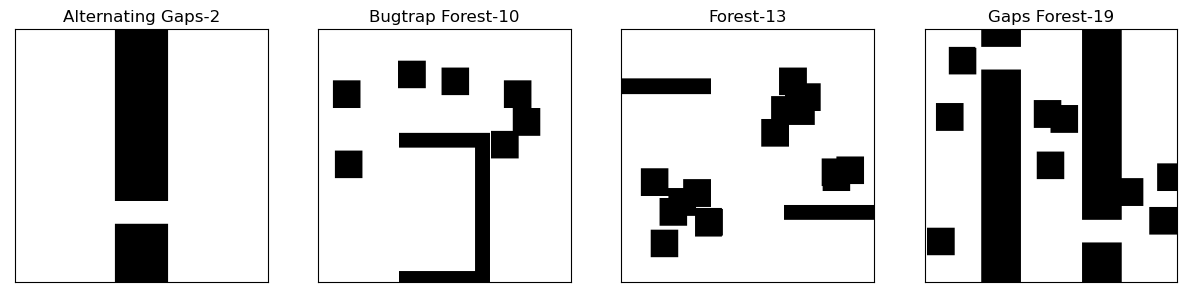

In [8]:
f1, ax1 = plt.subplots(1, 4, figsize=(15,15))

# Maps
for i in range(4):
    map_path = cfg['maps'][f'map{cfg["map_idxs"][i]-1}']["path"]
    # read the image
    im = Image.open(map_path)
    # show image
    ax1[i].imshow(im, cmap='gray')
    ax1[i].set_xticks([])
    ax1[i].set_yticks([])
    ax1[i].set_title(f"{MAPS[cfg['map_idxs'][i]]}-{cfg['map_idxs'][i]}")

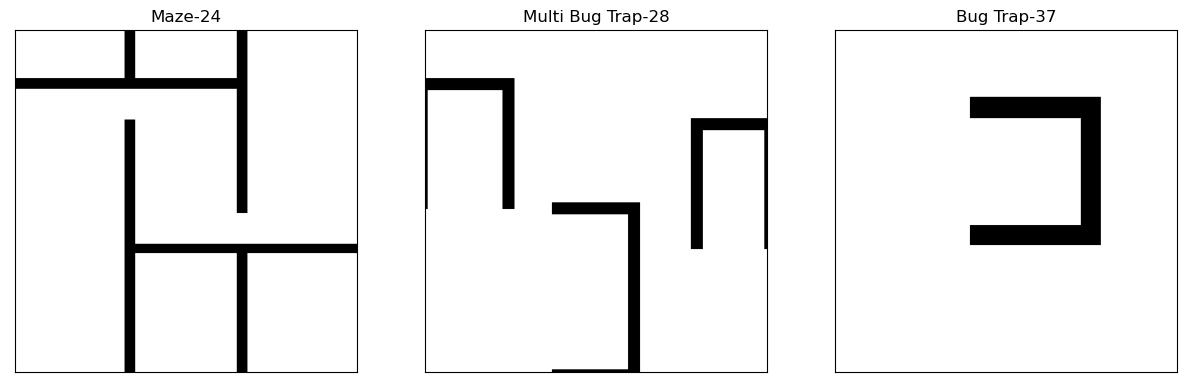

In [9]:
f2, ax2 = plt.subplots(1, 3, figsize=(15,15))
# Maps
for i in range(3):
    map_path = cfg['maps'][f'map{cfg["map_idxs"][i+4]-1}']["path"]
    # read the image
    im = Image.open(map_path)
    # show image
    ax2[i].imshow(im, cmap='gray')
    ax2[i].set_xticks([])
    ax2[i].set_yticks([])
    ax2[i].set_title(f"{MAPS[cfg['map_idxs'][i+4]]}-{cfg['map_idxs'][i+4]}")

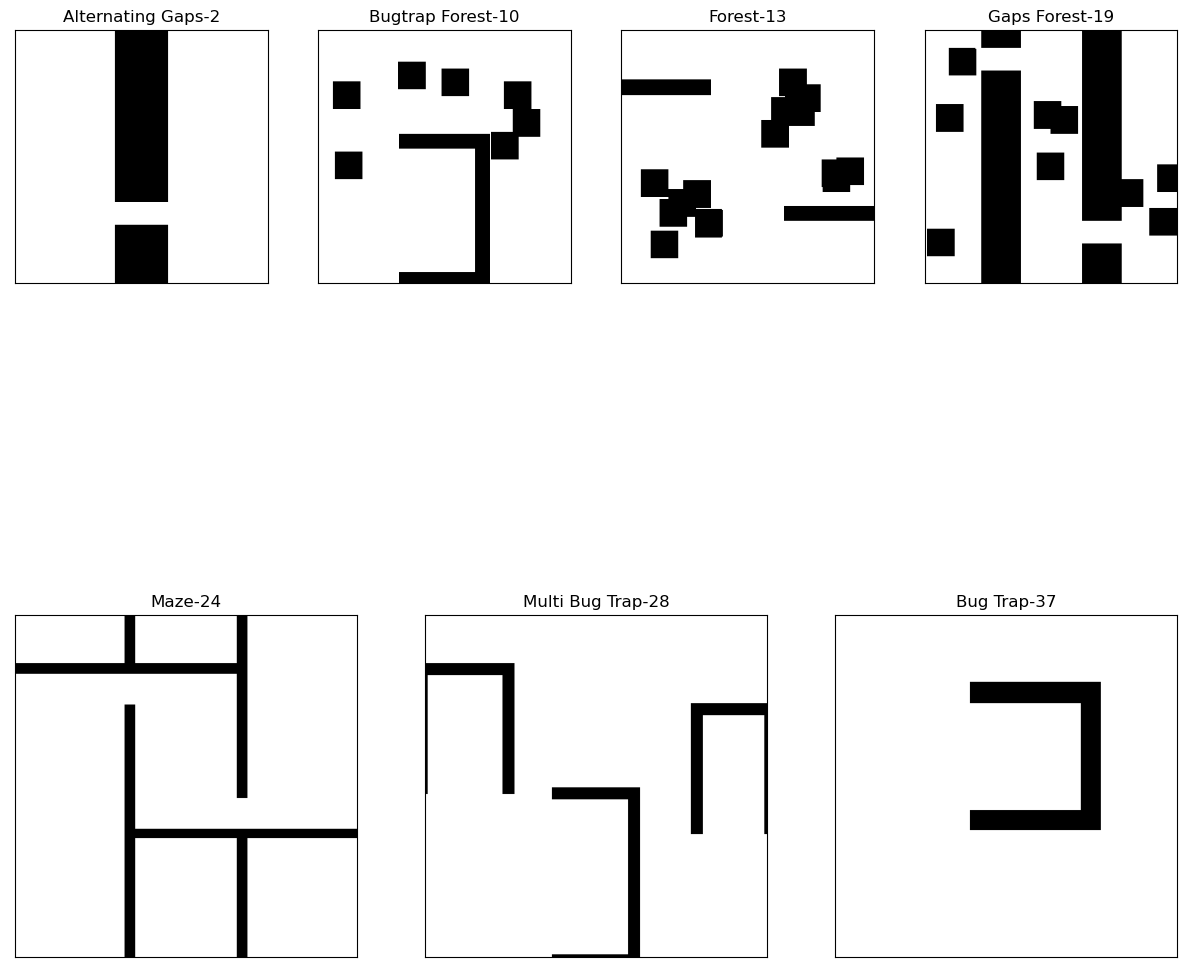

In [10]:
f = plt.figure(figsize=(15,15))
f.add_subplot(2,4,1)
f.add_subplot(2,4,2)
f.add_subplot(2,4,3)
f.add_subplot(2,4,4)
f.add_subplot(2,3,4)
f.add_subplot(2,3,5)
f.add_subplot(2,3,6)

# Maps
for i in range(7):
    map_path = cfg[z'maps'][f'map{cfg["map_idxs"][i]-1}']["path"]
    # read the image
    im = Image.open(map_path)
    # show image
    f.axes[i].imshow(im, cmap='gray')
    f.axes[i].set_xticks([])
    f.axes[i].set_yticks([])
    f.axes[i].set_title(f"{MAPS[cfg['map_idxs'][i]]}-{cfg['map_idxs'][i]}")

f.savefig('results/MapsGridPlot.png',bbox_inches='tight')

## Solution Cost vs Execution Time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


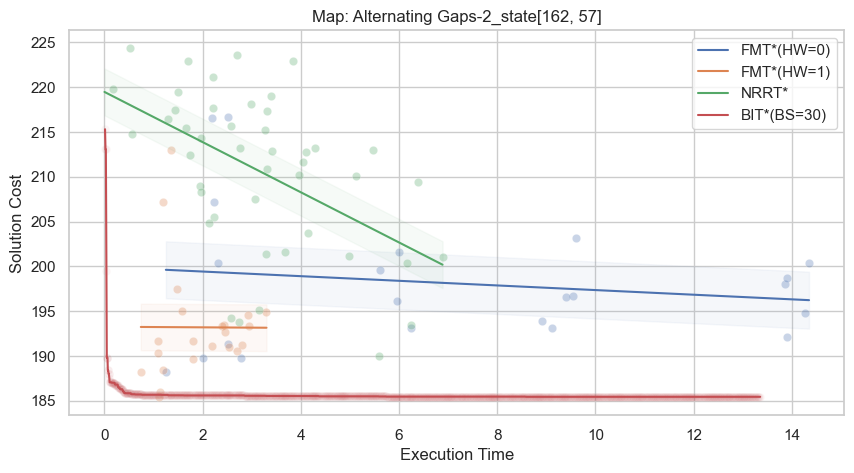

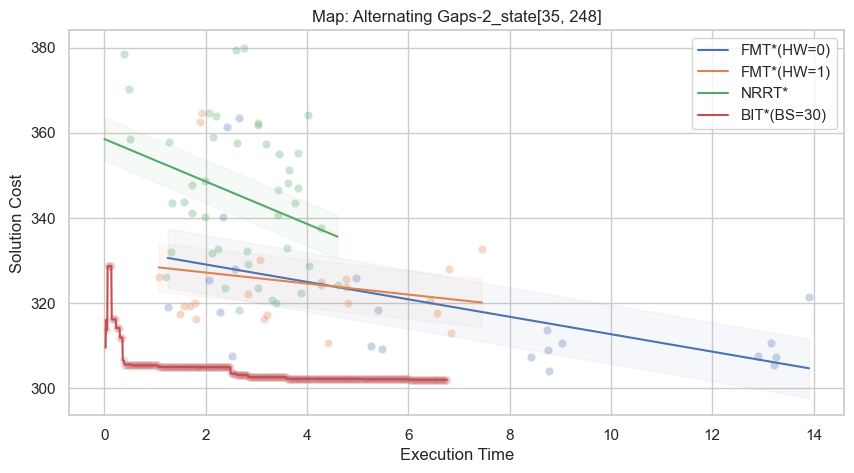

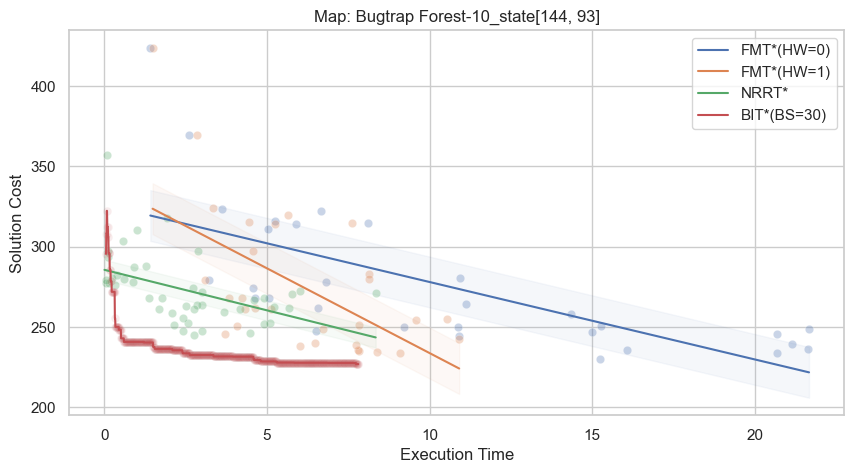

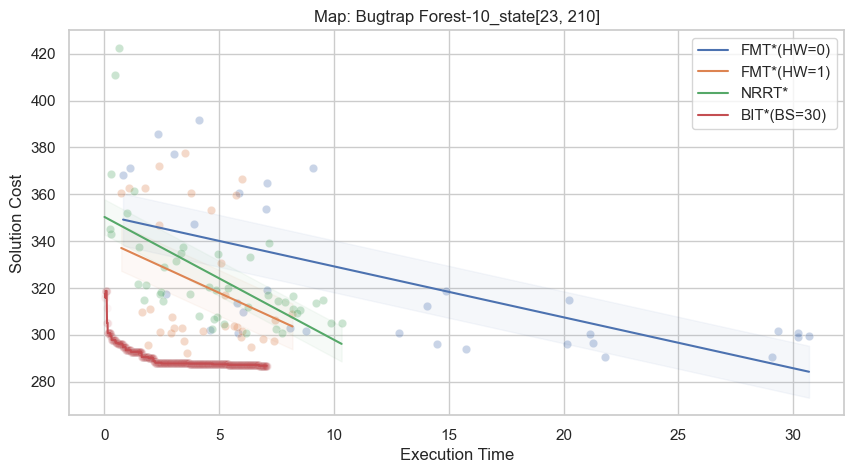

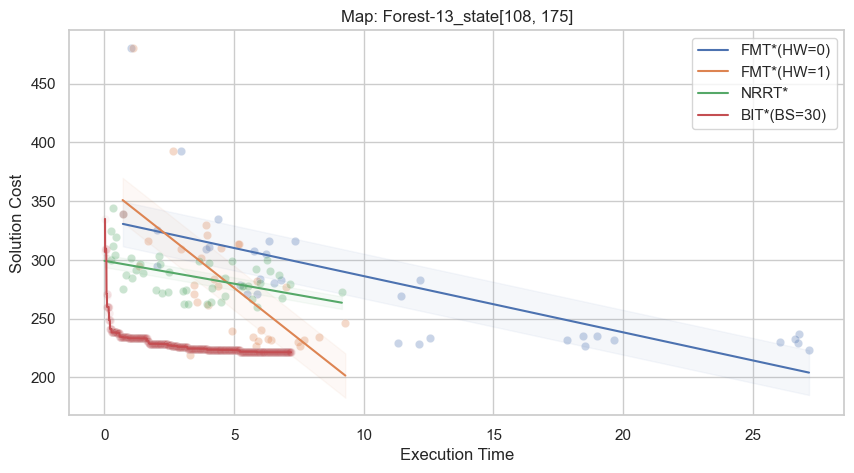

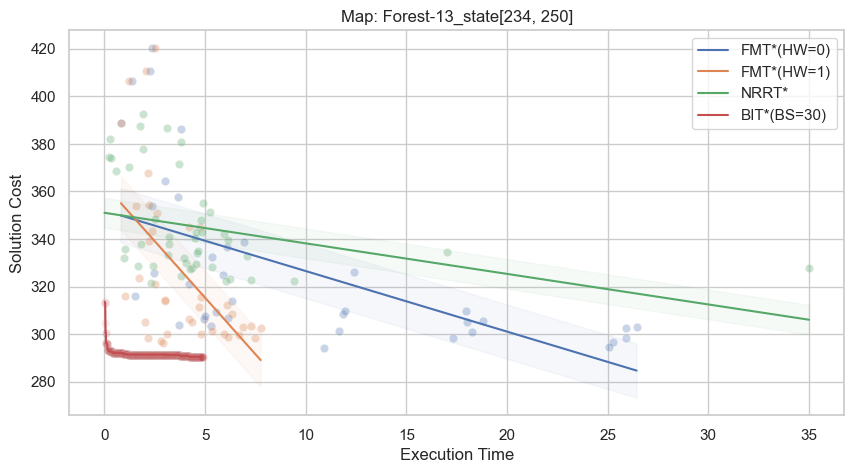

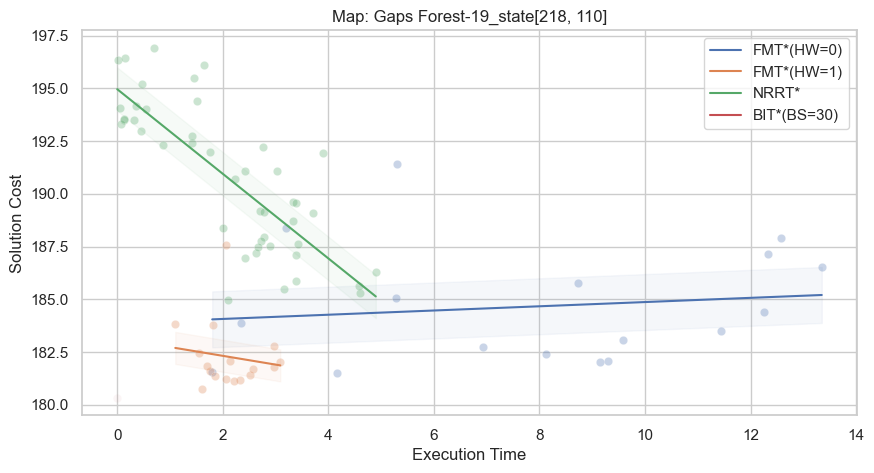

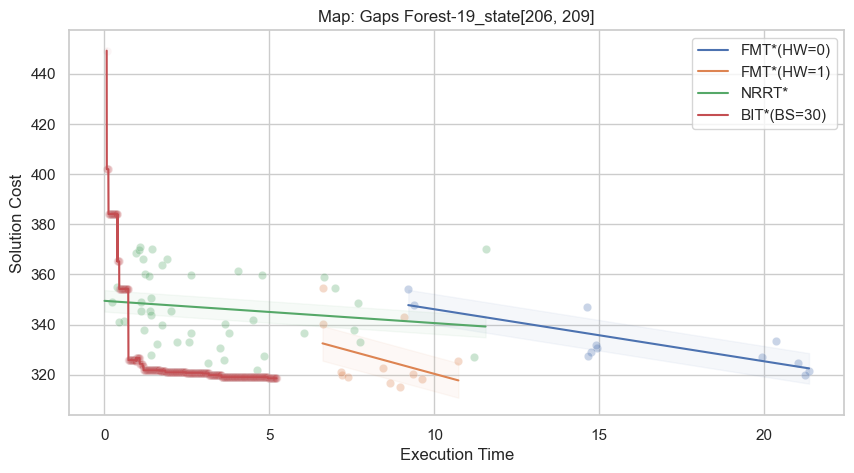

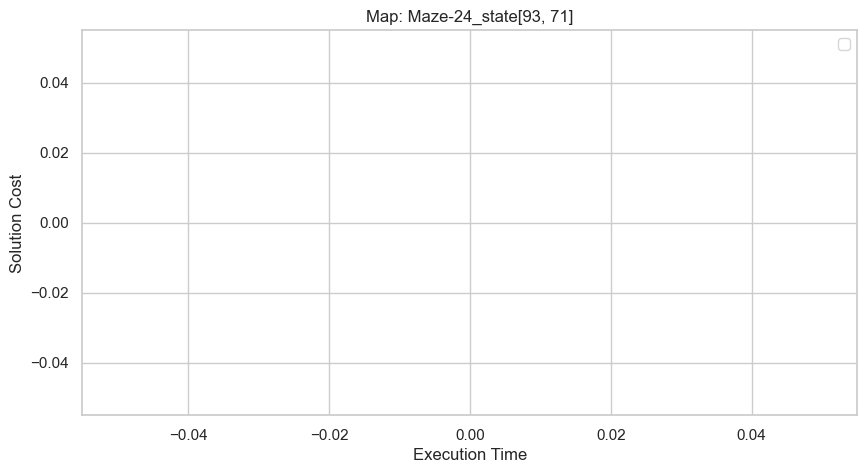

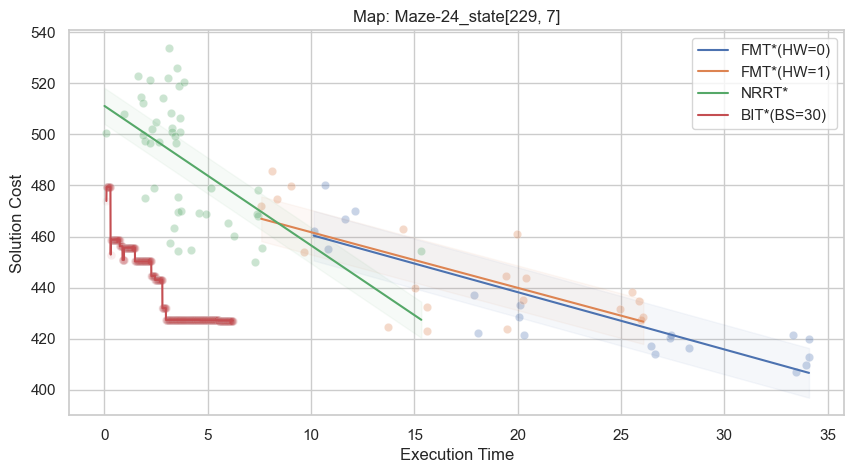

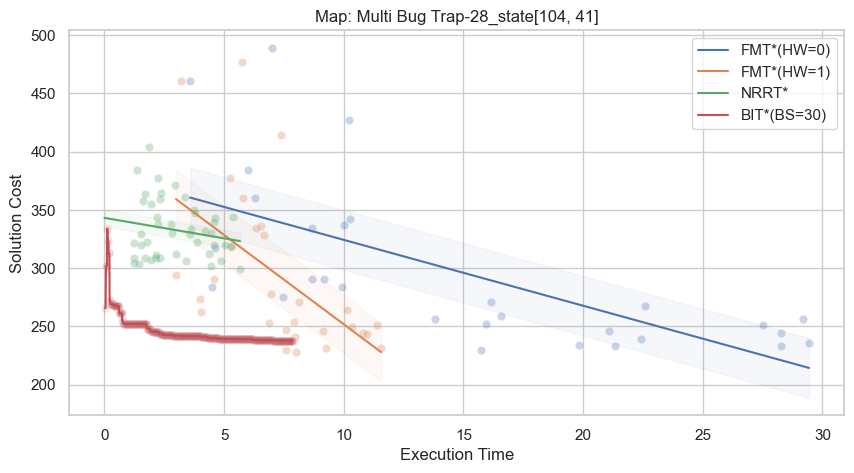

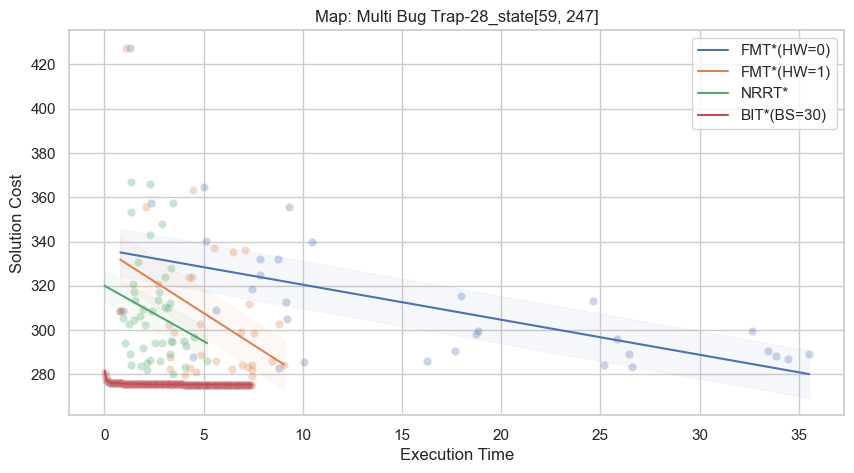

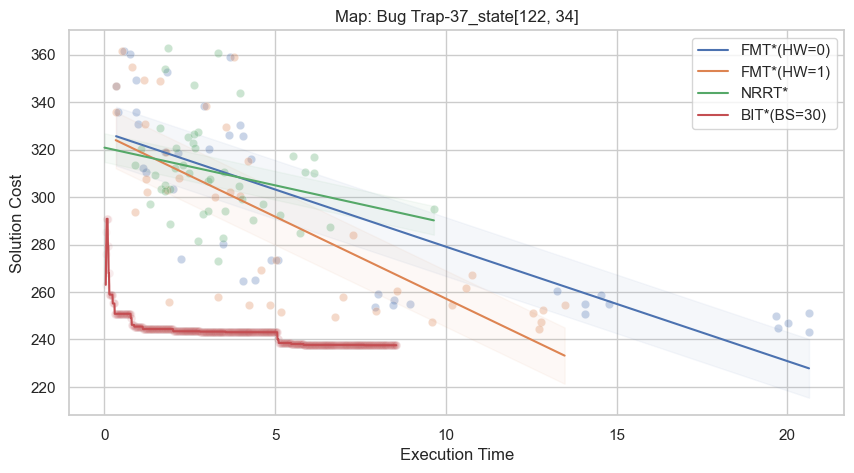

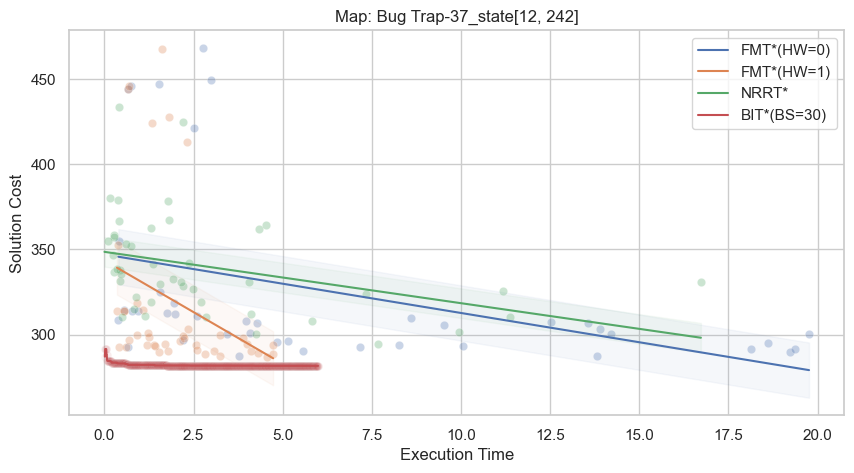

In [206]:
sns.set_theme(style="whitegrid")

for idx in dlist[0]["Map Id"].unique():    
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        col = sns.color_palette()
        ax.set_xlabel("Execution Time")
        ax.set_ylabel("Solution Cost")
        ax.set_title(f"Map: {MAPS[idx]}-{idx}_state{sp}")
        
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp) & (ddf["Any Path Found"])]
            scatterdf = mapi_data[["Timestep", "Current Path Cost"]]

            if sp != "[93, 71]":
                # fit trendline
                xp = np.linspace(min(scatterdf["Timestep"]), max(scatterdf['Timestep']), 100)
                z = np.polyfit(scatterdf['Timestep'], scatterdf['Current Path Cost'], 1)
                p = np.poly1d(z)
                q = pd.DataFrame({"Timestep": xp, "Current Path Cost": p(xp)})
                
                # 95% CI
                sigma = 2 * np.std(scatterdf["Current Path Cost"].astype("float"))/np.sqrt(len(scatterdf))
                lb = q["Current Path Cost"] - sigma
                ub = q["Current Path Cost"] + sigma

                # plot
                sns.scatterplot(data=scatterdf, x="Timestep", y="Current Path Cost", alpha=0.3, ax=ax, color=col[i])
                sns.lineplot(data=q, x="Timestep" ,y='Current Path Cost', label=f"FMT*(HW={HW[i]})", ax=ax, color=col[i])
                ax.fill_between(q["Timestep"], lb, ub, alpha=0.05, color=col[i])

        # NRRT
        mapi_data = nrrt_df[(nrrt_df["Map Id"] == idx) & (nrrt_df["Start Point"] == sp) & nrrt_df["Any Path Found"]]
        scatterdf = mapi_data[["Timestep", "Current Path Cost"]]
        
        if sp != "[93, 71]":
            # fit trendline
            xp = np.linspace(0, max(scatterdf['Timestep']), 100)
            z = np.polyfit(scatterdf['Timestep'], scatterdf['Current Path Cost'], 1)
            p = np.poly1d(z)
            q = pd.DataFrame({"Timestep": xp, "Current Path Cost": p(xp)})
                        
            # 95% CI
            sigma = 2 * np.std(scatterdf["Current Path Cost"])/np.sqrt(len(scatterdf))
            lb = q["Current Path Cost"] - sigma
            ub = q["Current Path Cost"] + sigma

            # plot
            sns.scatterplot(data=scatterdf, x="Timestep", y="Current Path Cost", alpha=0.3, ax=ax, color=col[2])
            sns.lineplot(data=q, x="Timestep" ,y='Current Path Cost', label="NRRT*", ax=ax, color=col[2])
            ax.fill_between(q["Timestep"], lb, ub, alpha=0.05, color=col[2])
            
        # BIT* - BS 30
        mapi_data = bitdf2[(bitdf2["Map Id"] == idx) & (bitdf2["Start Point"] == sp) & (bitdf2["Any Path Found"])]
        plotdf = mapi_data[["Timestep", "Current Path Cost", "Iteration"]].groupby("Iteration").mean()
        
        sigma = 2 * np.std(plotdf["Current Path Cost"])/np.sqrt(len(plotdf))
        lb = plotdf["Current Path Cost"] - sigma
        ub = plotdf["Current Path Cost"] + sigma
        
        sns.scatterplot(data=plotdf, x="Timestep", y='Current Path Cost', alpha=0.05, ax=ax, color=col[3])
        sns.lineplot(data=plotdf, x="Timestep", y='Current Path Cost', label="BIT*(BS=30)", ax=ax, color=col[3])
        ax.fill_between(plotdf["Timestep"], lb, ub, alpha=0.05, color=col[3])
        ax.legend(loc='upper right')

        # Save plot
        # fig.savefig(f"results/scVet_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")


# Success Rate vs Execution Time

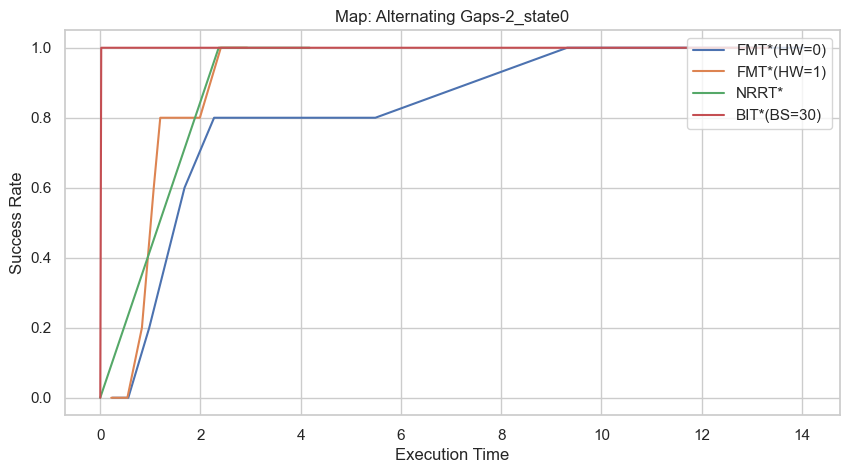

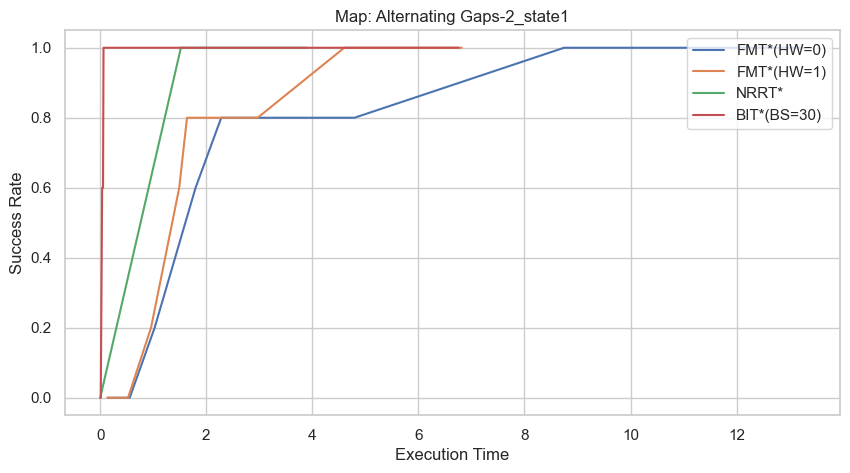

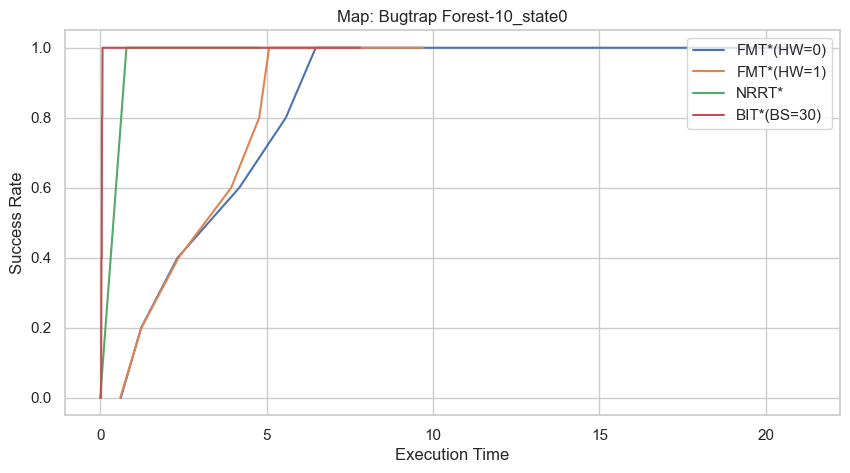

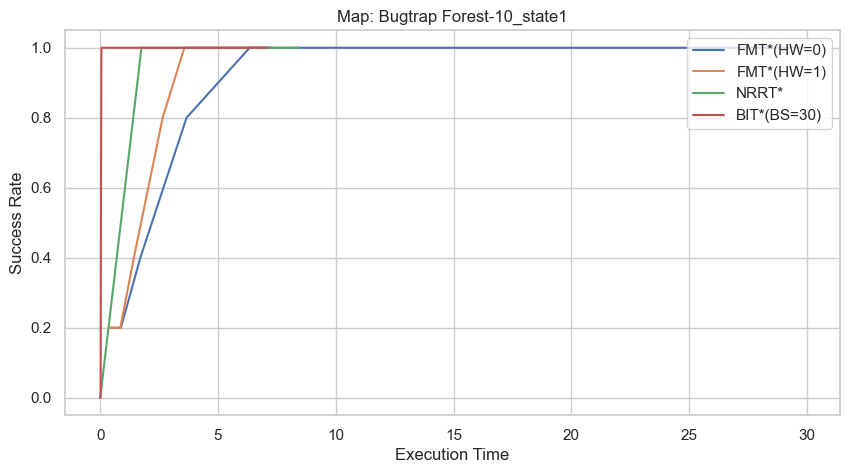

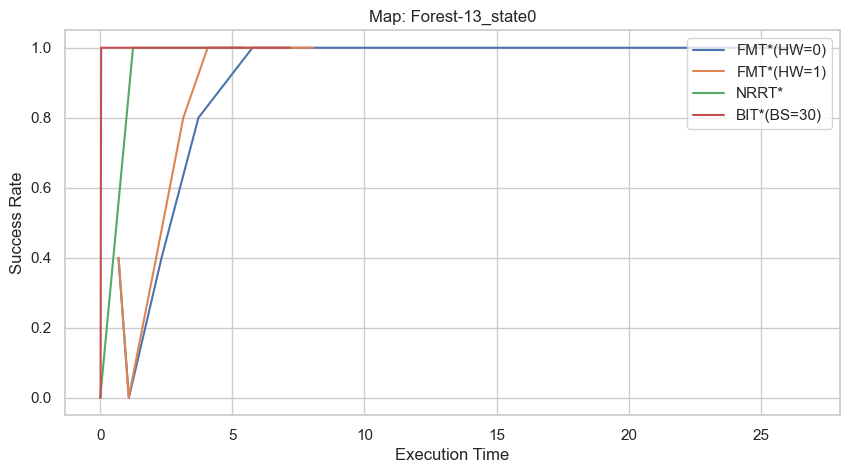

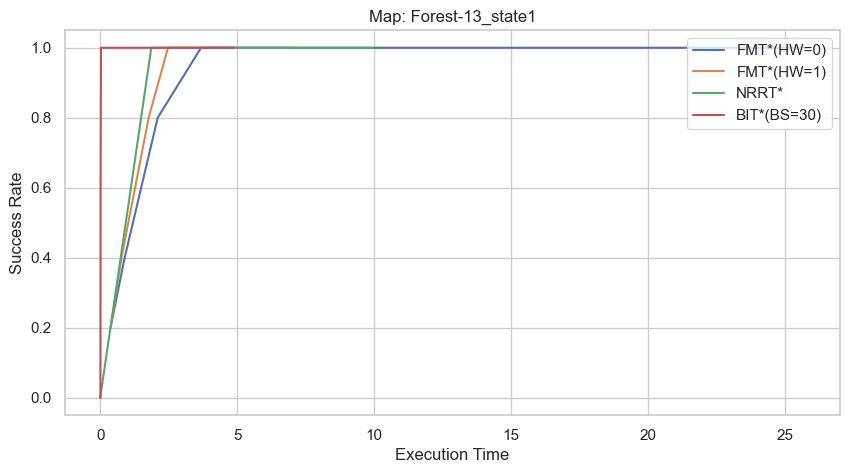

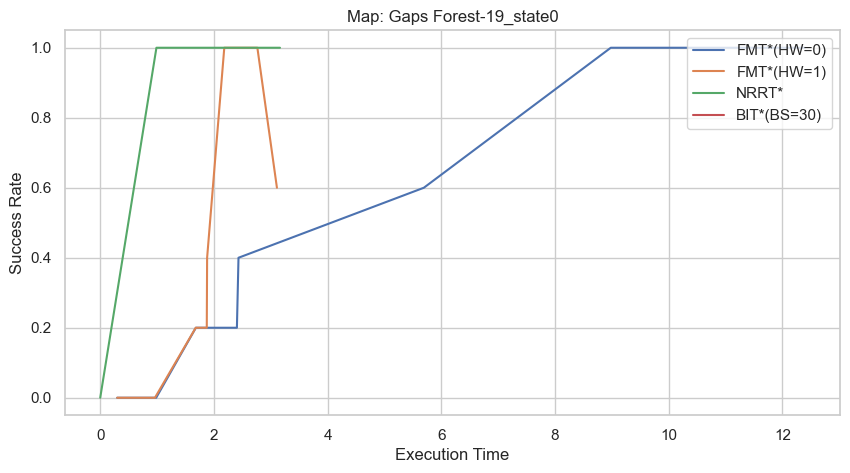

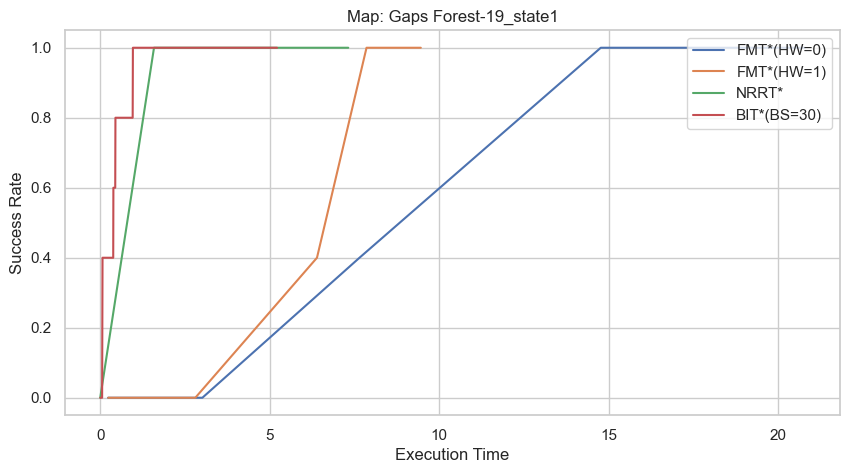

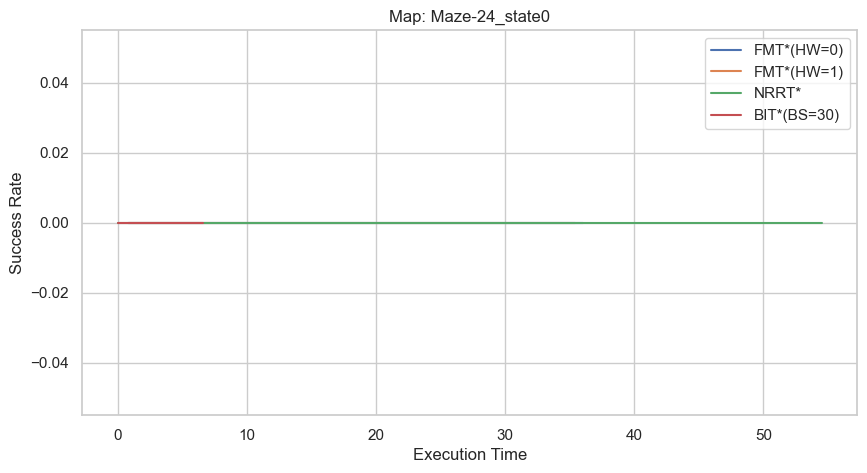

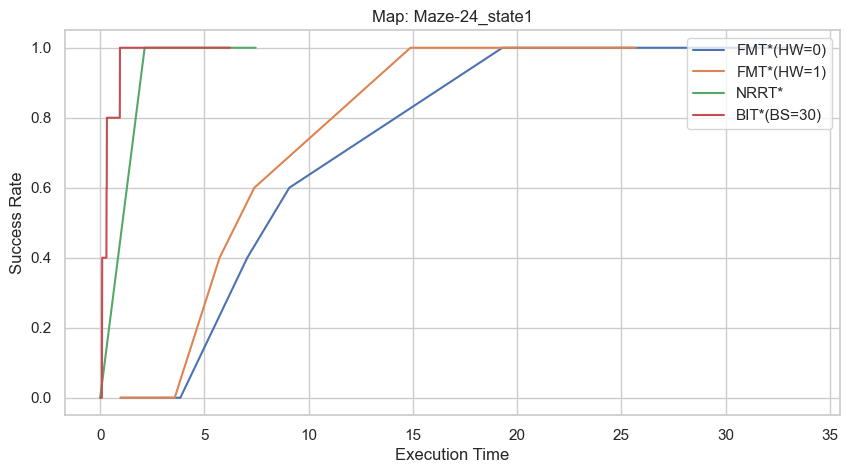

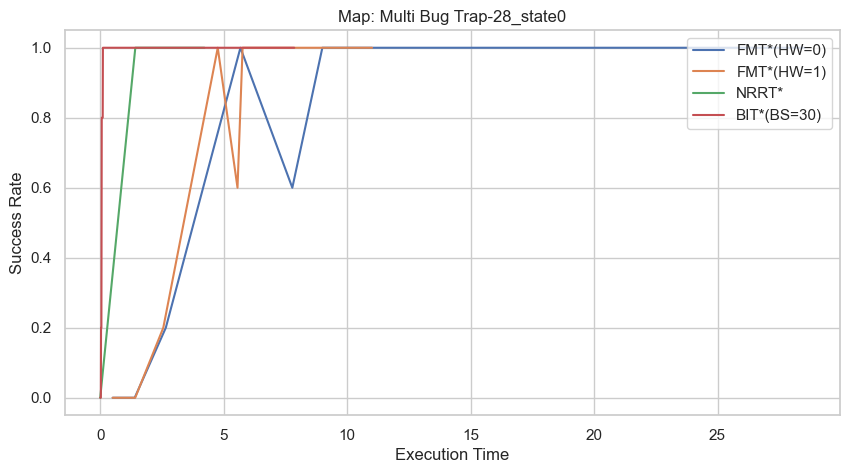

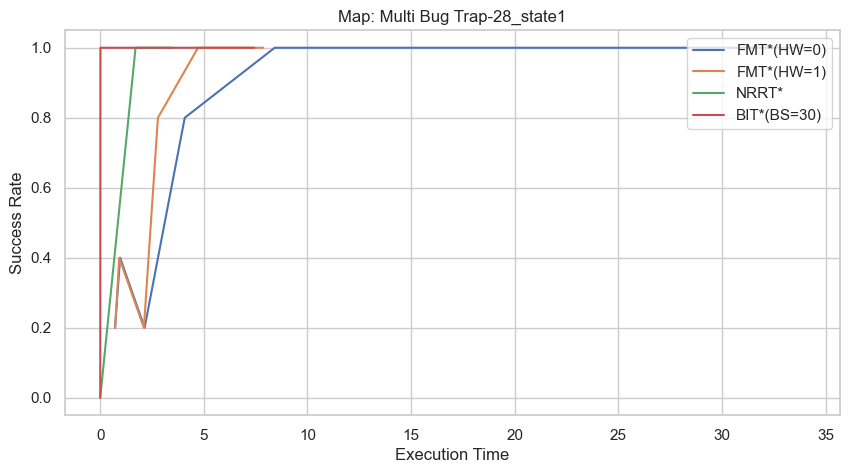

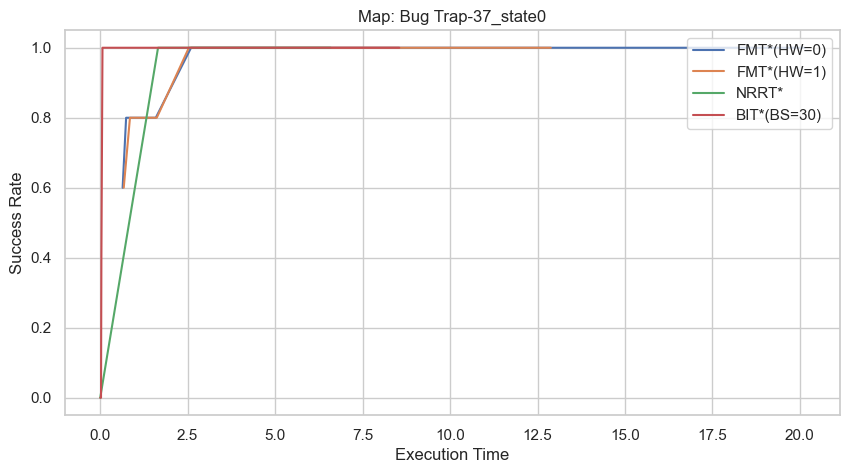

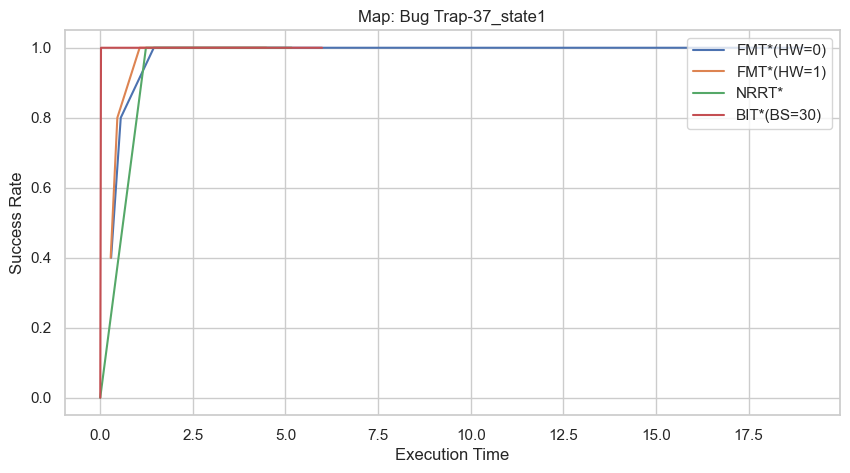

In [225]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        ax.set_xlabel("Execution Time")
        ax.set_ylabel("Success Rate")
        ax.set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")

        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = pd.concat([
                        mapi_data[["Timestep", "Batch Size"]].groupby(["Batch Size"]).mean(),
                        mapi_data[["Any Path Found", "Batch Size"]].groupby(["Batch Size"]).sum()/cfg["runs_per_map"]
                    ], axis=1)
            sns.lineplot(data=plotdf, x='Timestep', y="Any Path Found", label=f"FMT*(HW={HW[i]})")
        
        # NRRT
        mapi_data = nrrt_df[(nrrt_df["Map Id"] == idx) & (nrrt_df["Start Point"] == sp)]
        plotdf = pd.concat([
            mapi_data[["Timestep", "Batch Size"]].groupby(["Batch Size"]).mean(),
            mapi_data[["Any Path Found", "Batch Size"]].groupby(["Batch Size"]).sum()/cfg["runs_per_map"]
        ], axis=1)
        
        # add 0,0
        plotdf.loc[-1] = [0,0]
        plotdf.index += 1
        df.sort_index(inplace=True)
        
        # sort by execution time
        plotdf.sort_values('Timestep', inplace=True)
        sns.lineplot(data=plotdf, x='Timestep', y="Any Path Found", label="NRRT*")
        
        # BIT* - BS 30
        mapi_data = bitdf2[(bitdf2["Map Id"] == idx) & (bitdf2["Start Point"] == sp)]
        plotdf = pd.concat([
                        mapi_data[["Timestep", "Iteration"]].groupby(["Iteration"]).mean(),
                        mapi_data[["Any Path Found", "Iteration"]].groupby(["Iteration"]).sum()/cfg["runs_per_map"]
                    ], axis=1)
        sns.lineplot(data=plotdf, x='Timestep', y="Any Path Found", label="BIT*(BS=30)")
        ax.legend(loc='upper right')
    # Save plot
        # fig.savefig(f"results/srVet_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")

# Sample Count vs Collision Check

C:\Users\Jimmy Woo\AppData\Local\Temp\ipykernel_6208\3110506496.py:26: RuntimeWarning: invalid value encountered in log
  q = pd.DataFrame({"Cumulative Num Sampled": xp, "Num Collision Checks Transformed": np.log(p(xp))})
C:\Users\Jimmy Woo\AppData\Local\Temp\ipykernel_6208\3110506496.py:26: RuntimeWarning: invalid value encountered in log
  q = pd.DataFrame({"Cumulative Num Sampled": xp, "Num Collision Checks Transformed": np.log(p(xp))})
C:\Users\Jimmy Woo\AppData\Local\Temp\ipykernel_6208\3110506496.py:26: RuntimeWarning: invalid value encountered in log
  q = pd.DataFrame({"Cumulative Num Sampled": xp, "Num Collision Checks Transformed": np.log(p(xp))})
C:\Users\Jimmy Woo\AppData\Local\Temp\ipykernel_6208\3110506496.py:26: RuntimeWarning: invalid value encountered in log
  q = pd.DataFrame({"Cumulative Num Sampled": xp, "Num Collision Checks Transformed": np.log(p(xp))})
C:\Users\Jimmy Woo\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3378: RankWarn

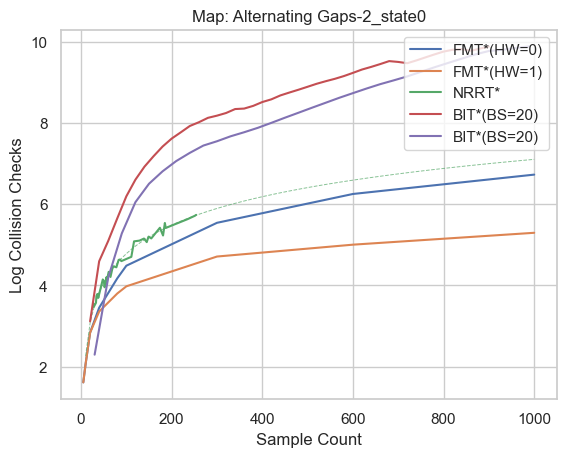

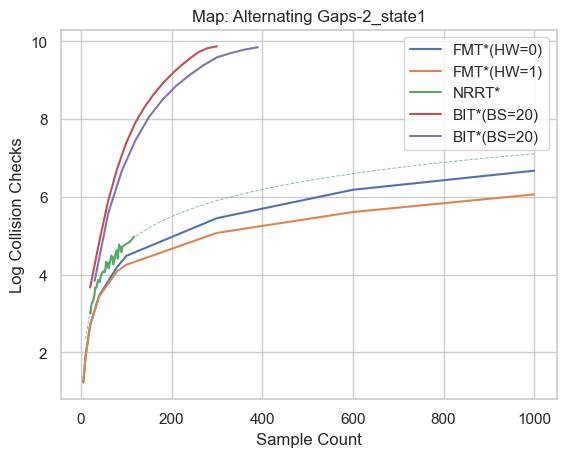

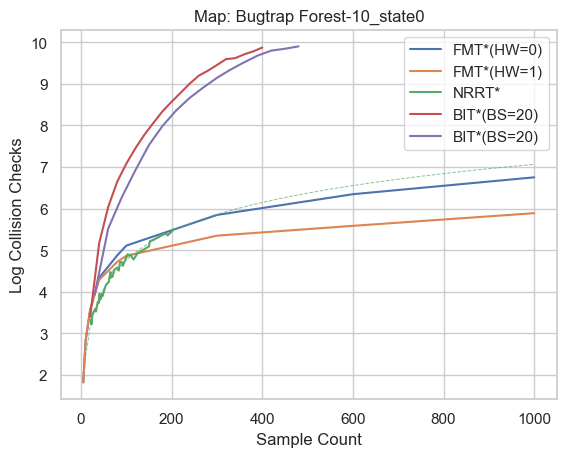

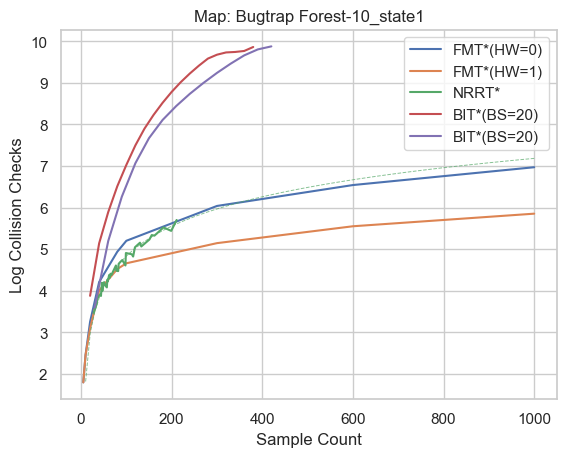

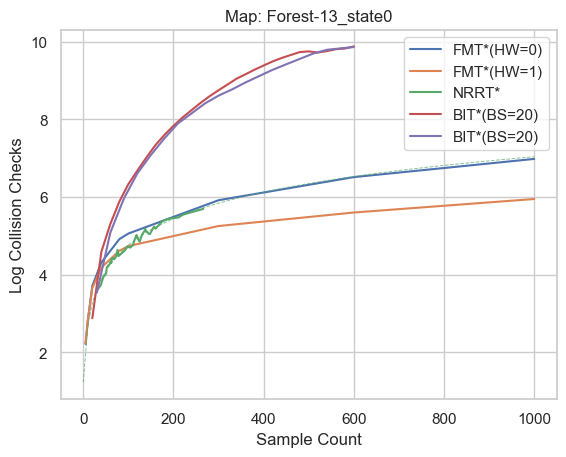

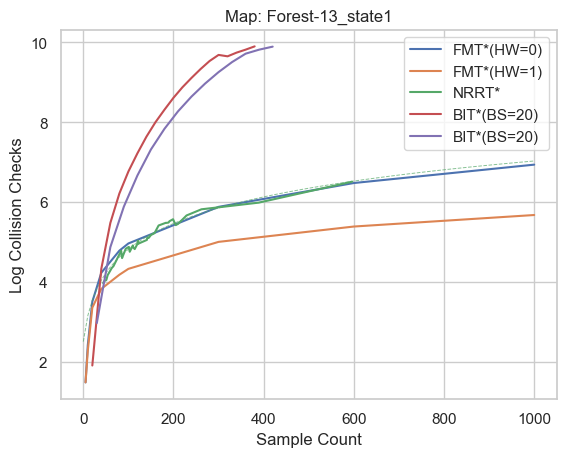

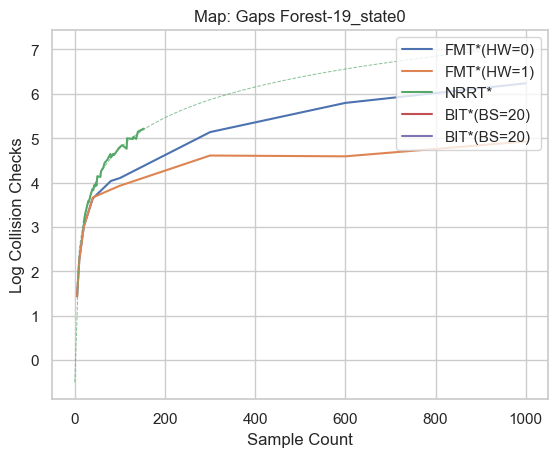

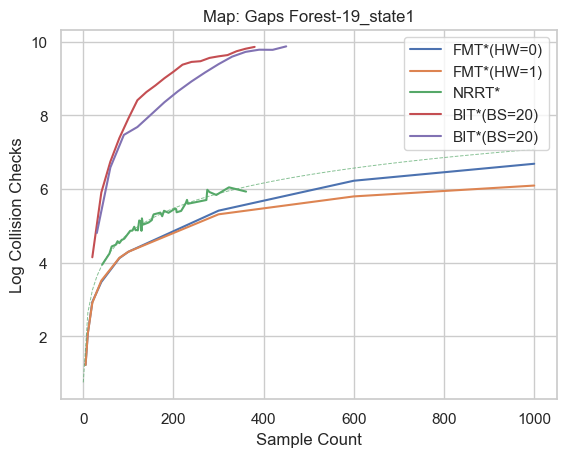

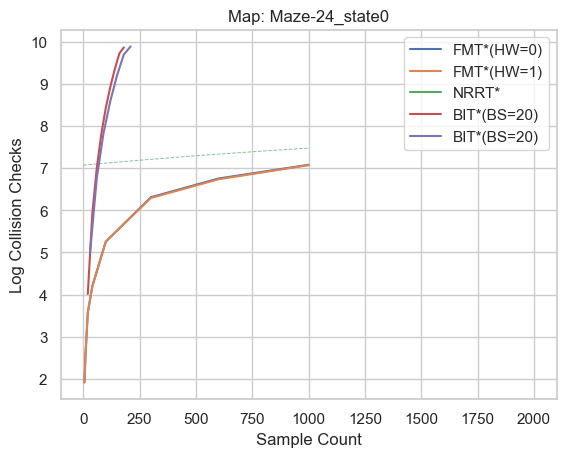

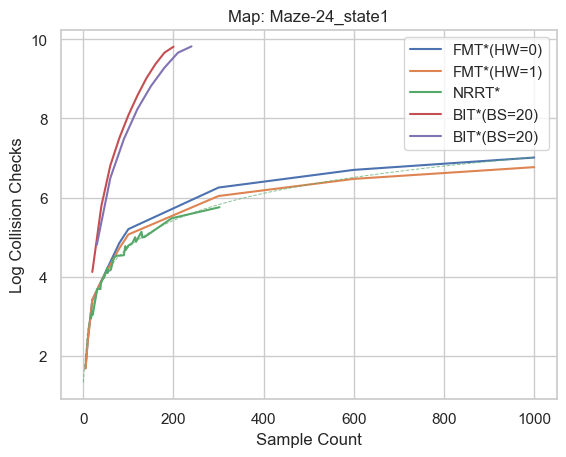

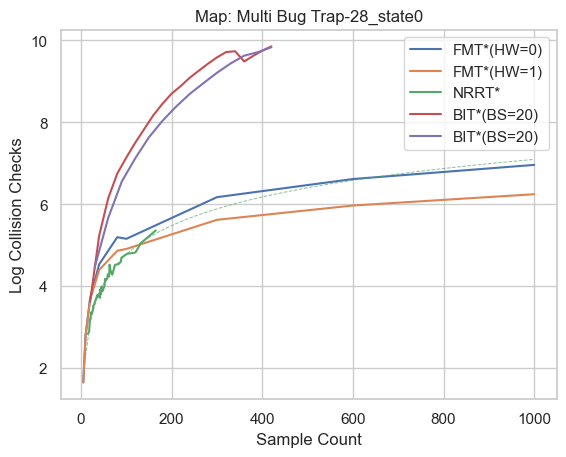

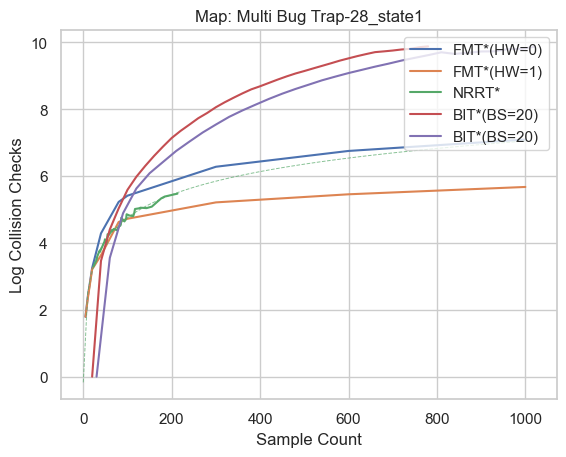

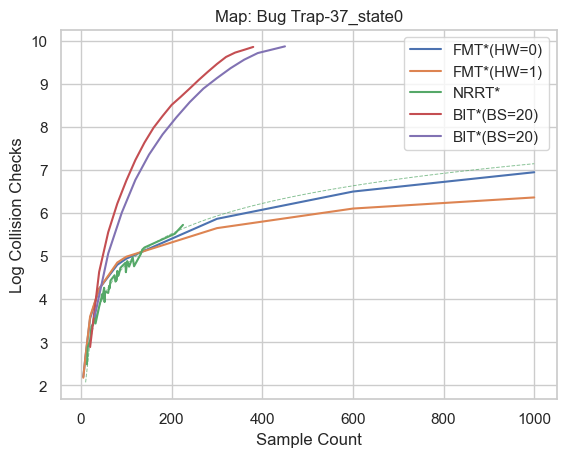

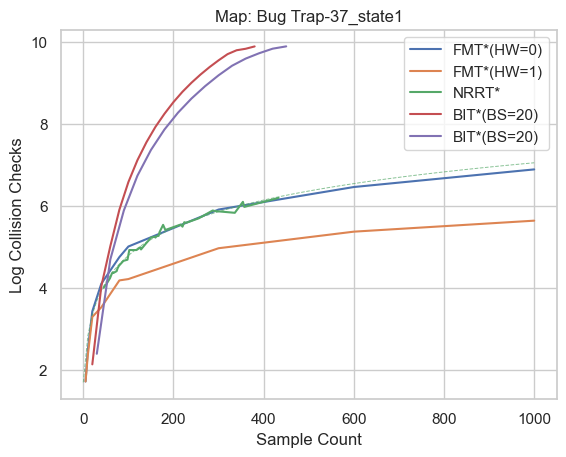

In [240]:
col = sns.color_palette()

for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots()
        ax.set_xlabel("Sample Count")
        ax.set_ylabel("Log Collision Checks")
        ax.set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        
        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = mapi_data[["Batch Size", "Num Collision Checks"]].groupby("Batch Size").mean().reset_index()
            plotdf["Num Collision Checks Transformed"] = np.log(plotdf["Num Collision Checks"])
            sns.lineplot(data=plotdf, x="Batch Size", y="Num Collision Checks Transformed", label=f"FMT*(HW={HW[i]})", color=col[i], ax=ax)
            
        # NRRT
        mapi_data = nrrt_df[(nrrt_df["Map Id"] == idx) & (nrrt_df["Start Point"] == sp)]
        plotdf = mapi_data[["Cumulative Num Sampled", "Num Collision Checks"]].groupby("Cumulative Num Sampled").mean().reset_index()
        plotdf["Num Collision Checks Transformed"] = np.log(plotdf["Num Collision Checks"])
            
        # fit trendline
        xp = np.linspace(0, 1000, 100)
        z = np.polyfit(plotdf['Cumulative Num Sampled'], plotdf['Num Collision Checks'], 1)
        p = np.poly1d(z)
        q = pd.DataFrame({"Cumulative Num Sampled": xp, "Num Collision Checks Transformed": np.log(p(xp))})
        
        sns.lineplot(data=plotdf, x="Cumulative Num Sampled", y="Num Collision Checks Transformed", label="NRRT*", color=col[2], ax=ax)
        sns.lineplot(data=q, x="Cumulative Num Sampled", y="Num Collision Checks Transformed", linestyle='--', linewidth=0.7, alpha=0.7, color=col[2], ax=ax)
        
        # BIT* BS-20
        mapi_data = bitdf1[(bitdf1["Map Id"] == idx) & (bitdf1["Start Point"] == sp)]
        plotdf = mapi_data[["Cumulative Num Sampled", "Num Collision Checks"]].groupby("Cumulative Num Sampled").mean().reset_index()
        plotdf["Num Collision Checks Transformed"] = np.log(plotdf["Num Collision Checks"])
        sns.lineplot(data=plotdf, x="Cumulative Num Sampled", y="Num Collision Checks Transformed", label="BIT*(BS=20)", color=col[3], ax=ax)
        
        # BIT* BS-30
        mapi_data = bitdf2[(bitdf2["Map Id"] == idx) & (bitdf2["Start Point"] == sp)]
        plotdf = mapi_data[["Cumulative Num Sampled", "Num Collision Checks"]].groupby("Cumulative Num Sampled").mean().reset_index()
        plotdf["Num Collision Checks Transformed"] = np.log(plotdf["Num Collision Checks"])
        sns.lineplot(data=plotdf, x="Cumulative Num Sampled", y="Num Collision Checks Transformed", label="BIT*(BS=20)", color=col[4], ax=ax)
        ax.legend(loc='upper right')
        # Save plot
        # fig.savefig(f"results/scVcc_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")

## BIT*
- BIT* with higher batch size has fewer collision checks for a given sample count
- As the sample count approaches $\infty$, collision checks for BIT* would approach that of FMT*

# Success Rate vs Sample count

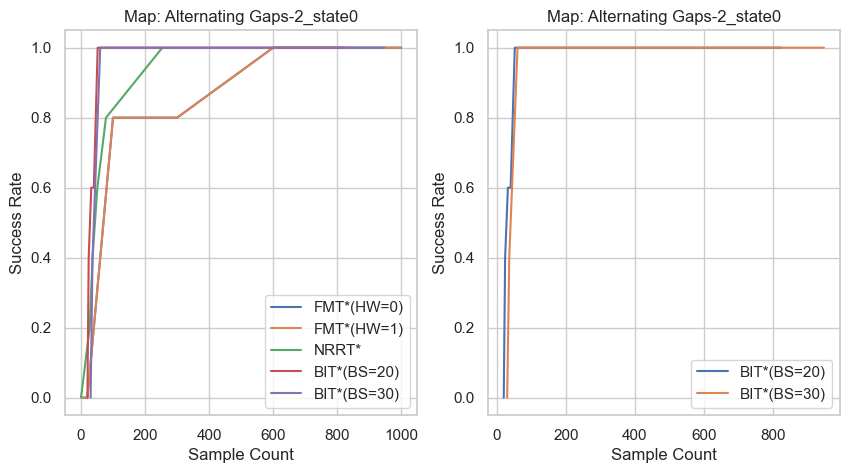

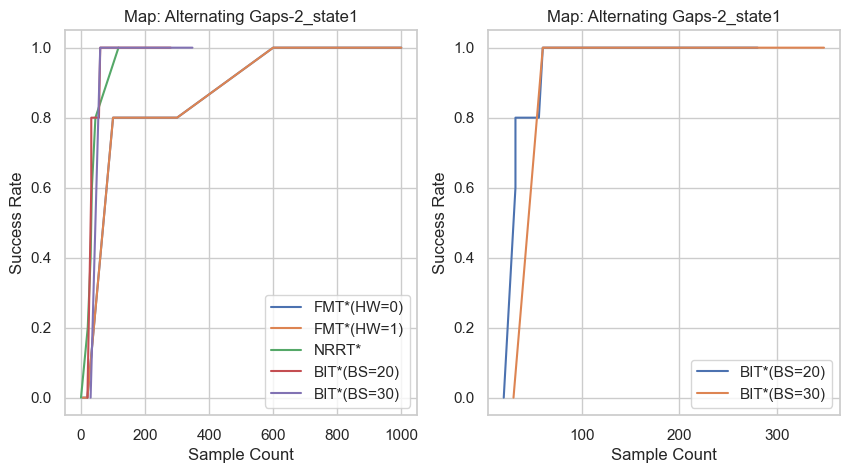

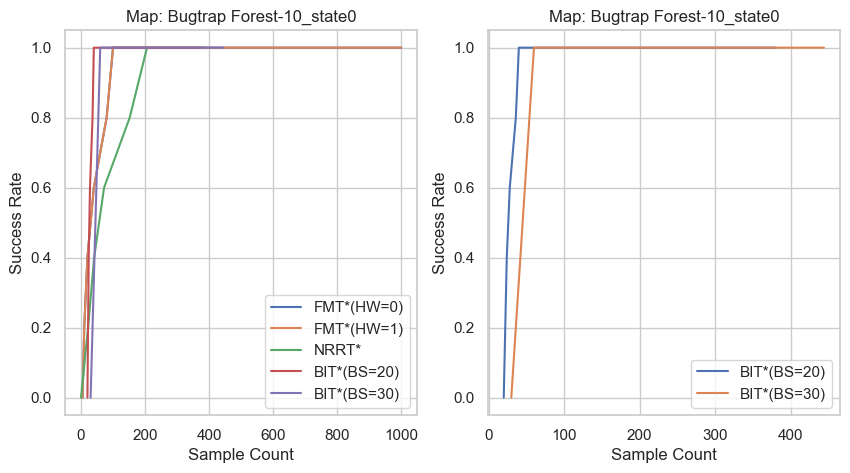

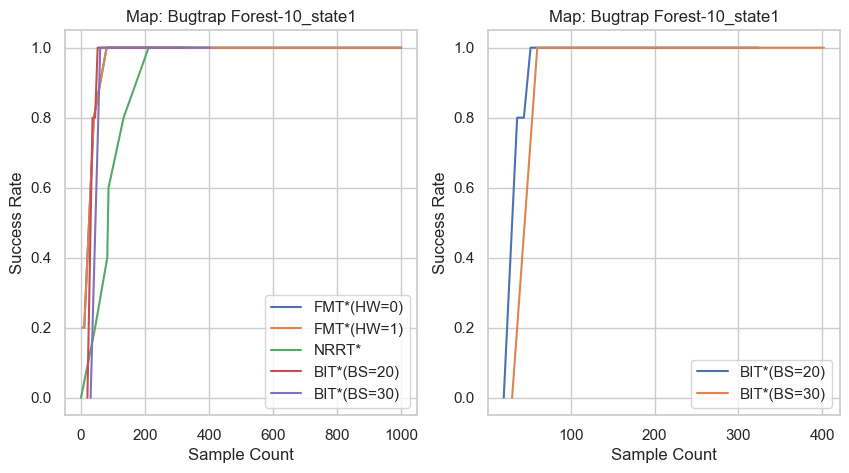

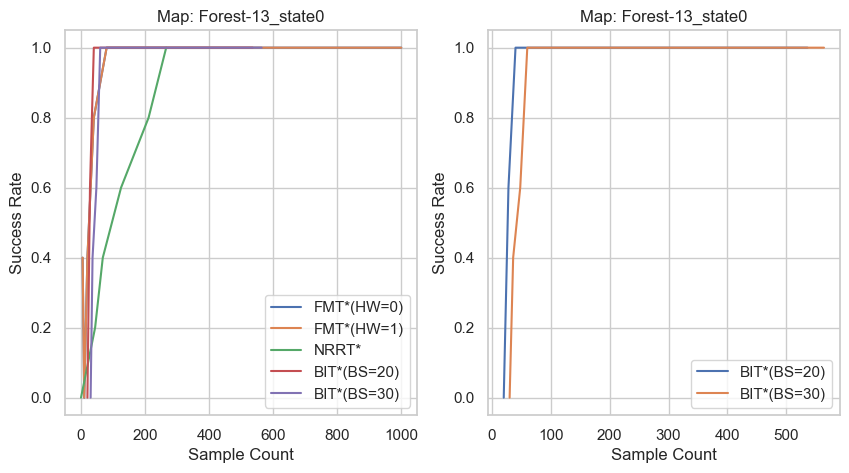

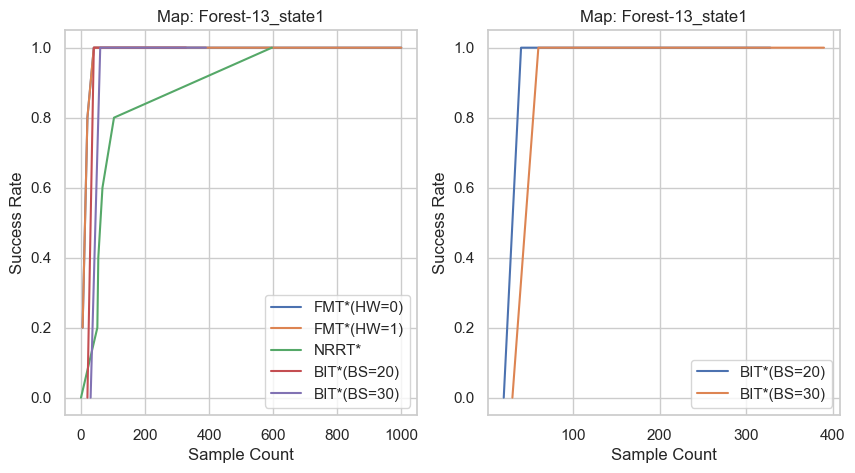

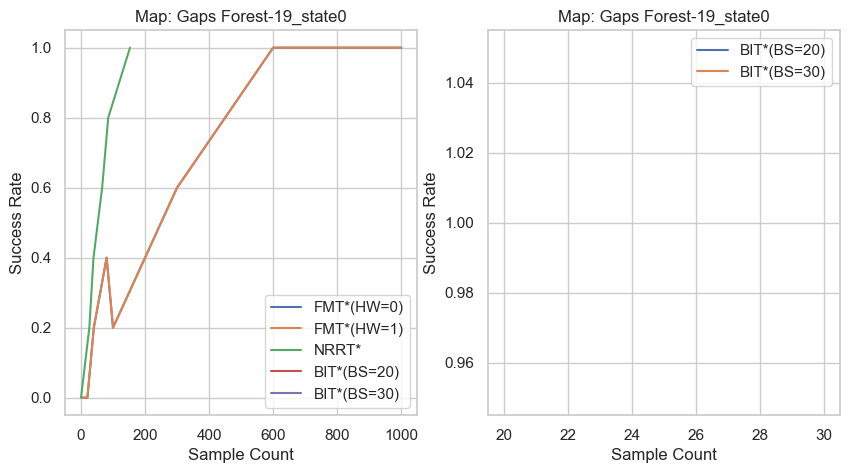

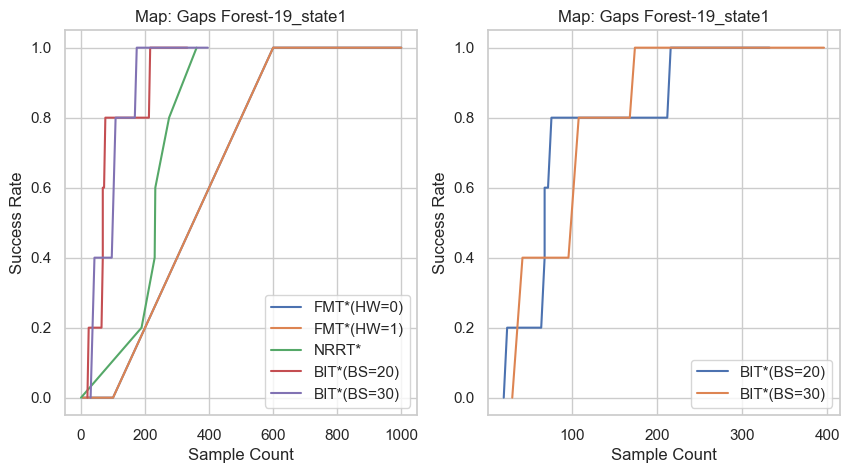

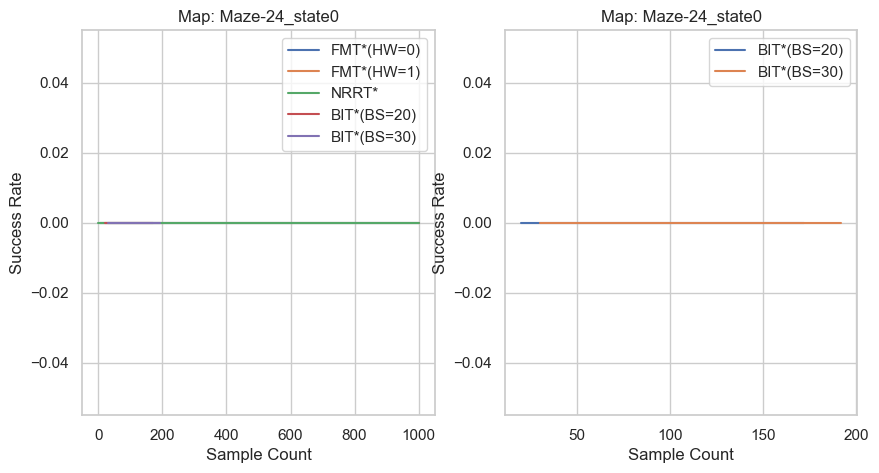

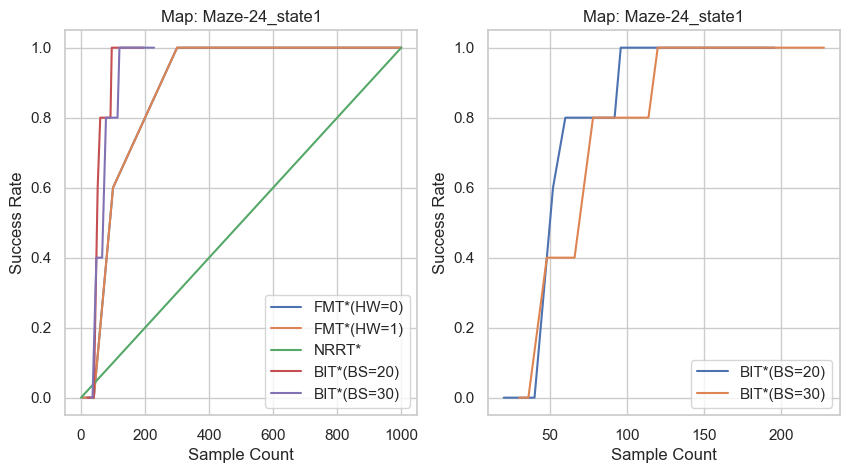

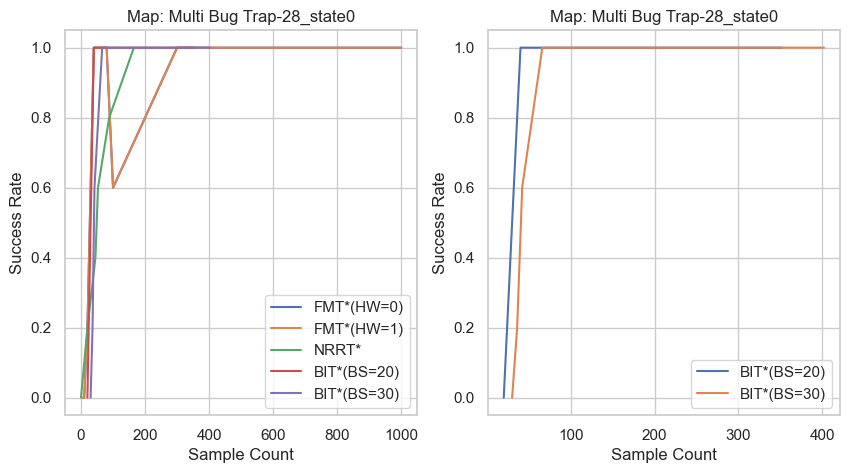

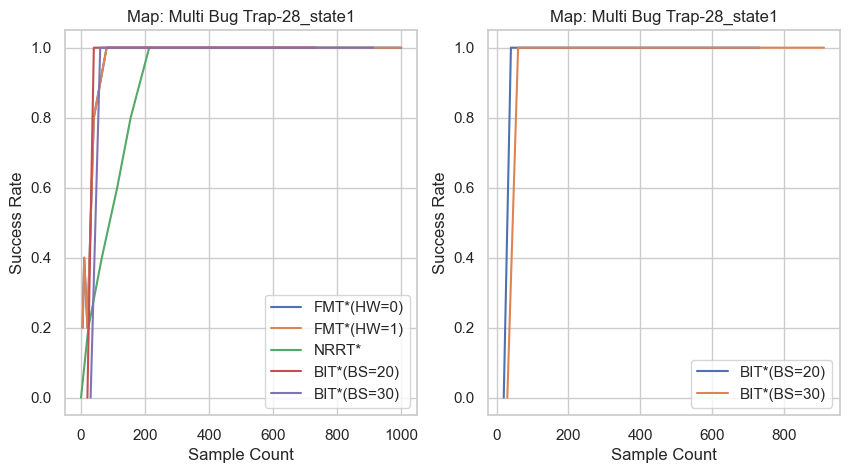

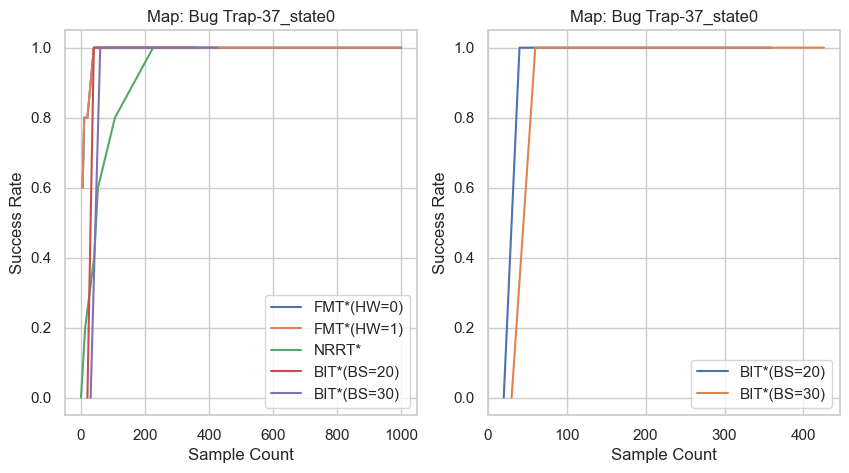

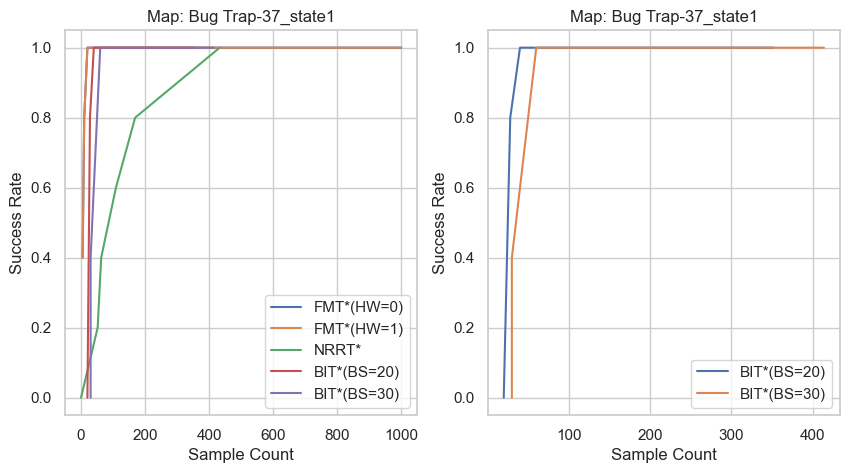

In [242]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].set_xlabel("Sample Count")
        ax[0].set_ylabel("Success Rate")
        ax[0].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        ax[1].set_xlabel("Sample Count")
        ax[1].set_ylabel("Success Rate")
        ax[1].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = (mapi_data[["Any Path Found", "Batch Size"]].groupby(["Batch Size"]).sum()/cfg["runs_per_map"]).reset_index()

            ax[0].plot(plotdf["Batch Size"], plotdf["Any Path Found"], label=f"FMT*(HW={HW[i]})")
        # NRRT
        mapi_data = nrrt_df[(nrrt_df["Map Id"] == idx) & (nrrt_df["Start Point"] == sp)]
        ldf = mapi_data[["Iteration", "Cumulative Num Sampled", "Batch Size"]].reset_index()
        rdf = mapi_data[["Any Path Found", "Iteration", 'Batch Size']].groupby(["Batch Size", "Iteration"]).sum().groupby(level=0).cumsum().reset_index()
        plotdf = ldf.merge(rdf, on=['Iteration', "Batch Size"])
        plotdf['Any Path Found'] /= 5
                
        if MAPS[idx] != 'Maze':
            max_it = np.max(plotdf[plotdf['Any Path Found'] == 1]['Iteration'])
            b_size = plotdf[(plotdf['Any Path Found'] == 1) & (plotdf['Iteration'] == max_it)]['Batch Size'].values[0]
            plotdf = plotdf[plotdf['Batch Size'] == b_size]
        else:
            plotdf = plotdf[plotdf['Batch Size'] == 5]
            plotdf['Cumulative Num Sampled'] = list(np.arange(200, 1200, 200))
        
        # add 0,0
        plotdf = plotdf[["Cumulative Num Sampled", "Any Path Found"]]
        plotdf.loc[-1] = [0,0]
        plotdf.index += 1
        plotdf = plotdf.sort_values("Cumulative Num Sampled")
        
        ax[0].plot(plotdf["Cumulative Num Sampled"], plotdf["Any Path Found"], label="NRRT*")
        
        
        # BIT*: BS-20
        for i in range(2):
            mapi_data = bitdf1[(bitdf1["Map Id"] == idx) & (bitdf1["Start Point"] == sp)]
            plotdf = pd.concat([
                            mapi_data[["Cumulative Num Sampled", "Iteration"]].groupby(["Iteration"]).mean(),
                            mapi_data[["Any Path Found", "Iteration"]].groupby(["Iteration"]).sum()/cfg["runs_per_map"]
                        ], axis=1)
            ax[i].plot(plotdf["Cumulative Num Sampled"], plotdf["Any Path Found"], label="BIT*(BS=20)")
            ax[i].legend()
        # BIT*: BS-30
        for i in range(2):
            mapi_data = bitdf2[(bitdf2["Map Id"] == idx) & (bitdf2["Start Point"] == sp)]
            plotdf = pd.concat([
                            mapi_data[["Cumulative Num Sampled", "Iteration"]].groupby(["Iteration"]).mean(),
                            mapi_data[["Any Path Found", "Iteration"]].groupby(["Iteration"]).sum()/cfg["runs_per_map"]
                        ], axis=1)
            ax[i].plot(plotdf["Cumulative Num Sampled"], plotdf["Any Path Found"], label="BIT*(BS=30)")
            ax[i].legend()
        # Save plot
        # fig.savefig(f"results/srVsc_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")